In [46]:
import collections
import seaborn as sns
import numpy as np
import itertools as it
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from  imp import reload
import sys
import random
#sys.path.insert(1, '../mallows_kendall')
#sys.path.insert(1, '../permus_util')
import mallows_kendall as mk
import permutil as pu
import networkx as nx

In [2]:
def get_cycles(P):
    cycles = list()
    P2 = np.nan_to_num((P -1/2).clip(0))
    P2
    G = nx.from_numpy_matrix(P2, create_using=nx.MultiDiGraph())
    for cycle in nx.simple_cycles(G):
        cycles.append(cycle)
    return cycles

def plot_directed_graph(P):
    P2 = np.nan_to_num((P -1/2).clip(0))
    P2
    G = nx.from_numpy_matrix(P2, create_using=nx.MultiDiGraph())
    edge_labels=dict([((u,v,), np.round(d['weight'],2)) for u,v,d in G.edges(data=True)])
    pos=nx.spring_layout(G)
    edge_colors = ['black' for edge in G.edges()]
    nx.draw(G, pos, node_size=1000, edge_color=edge_colors, edge_cmap=plt.cm.Reds, arrows=True,  with_labels=True)
    plt.show()
    return G

def depth_dataframe(samples, n=5):
    res = list()
    P = pu.sample_to_marg_rel(samples)
    perms = np.unique(samples, axis=0)
    for perm in perms:
        depth = n*(n-1)/2 - pu.dist_to_sample(perm, P)
        res.append([perm, depth])
    df = pd.DataFrame(res, columns=['perm','depth'])
    df = df.sort_values('depth', ascending=False)
    df = df.reset_index(drop=True)
    return df

## From non-SST to SST samples via trimming by depth.

Here we want to create samples of rankings that have a non-SST empirical distribution. Then we will try to trimm this sample until the distribution becomes SST, and thus outputs no cycles.
Then, finding the median with usual methods becomes easy.

In [322]:
def trimming(samples, trimming_param=0.1, n=5):
    df = depth_dataframe(samples, n=n)
    if trimming_param < 1:
        nb_to_trim = trimming_param * len(df)
    else:
        nb_to_trim = trimming_param
    print(f"nb to trim = {nb_to_trim}")
    
    samples2 = np.copy(samples)
    perms_to_drop = list(df.loc[range( int(len(df)-nb_to_trim), len(df)),'perm'])
    #print(f"Least deep rankings to trim : {perms_to_drop}")
    for perm_to_drop in perms_to_drop:
        samples2 = [samples_ for samples_ in samples2 if not (samples_==perm_to_drop).all()]
    samples2 = np.asarray(samples2)
    return samples2

def dispersion(samples, median):
    disp = [mk.distance(sample, median) for sample in samples]
    return np.mean(disp)

In [323]:
def strategic_trimming(samples, trimming_param=0.1, method="while", n=5):
    nested_medians = list()
    depth_medians = list()
    cycles_list = list()
    dispersion_list = list()
    if isinstance(method, str):
        P = pu.sample_to_marg_rel(samples)
        cycles = get_cycles(P)
        new_df = depth_dataframe(samples, n=n)
        current_median = new_df.loc[0,"perm"]
        nested_medians.append(current_median)
        max_depth = np.max(new_df.depth)
        depth_medians.append(max_depth)
        dispersion_list.append(dispersion(samples, current_median))
        print(f"At the start, number of cycles = {len(cycles)} and max depth = {max_depth}")
        cycles_list.append(len(cycles))
        step_ = 0
        while len(cycles) > 0:
            step_ += 1
            samples = trimming(samples, trimming_param=trimming_param, n=n)
            new_df = depth_dataframe(samples, n=n)
            current_median = new_df.loc[0,"perm"]
            nested_medians.append(current_median)
            max_depth = np.max(new_df.depth)
            depth_medians.append(max_depth)
            dispersion_list.append(dispersion(samples, current_median))
            P = pu.sample_to_marg_rel(samples)
            cycles = get_cycles(P)
            print(f"Step {step_} number of cycles = {len(cycles)} and max depth = {max_depth}")
            cycles_list.append(len(cycles))
    else:
        P = pu.sample_to_marg_rel(samples)
        cycles = get_cycles(P)
        new_df = depth_dataframe(samples, n=n)
        current_median = new_df.loc[0,"perm"]
        nested_medians.append(current_median)
        depth_medians.append(new_df.loc[0,"depth"])
        dispersion_list.append(dispersion(samples, current_median))
        print(f"At the start, number of cycles = {len(cycles)}")
        cycles_list.append(len(cycles))
        step_ = 0
        for step in range(method):
            step_ += 1
            samples = trimming(samples, trimming_param=trimming_param, n=n)
            new_df = depth_dataframe(samples, n=n)
            current_median = new_df.loc[0,"perm"]
            nested_medians.append(current_median)
            depth_medians.append(new_df.loc[0,"depth"])
            dispersion_list.append(dispersion(samples, current_median))
            P = pu.sample_to_marg_rel(samples)
            cycles = get_cycles(P)
            print(f"Step {step_} number of cycles = {len(cycles)}")
            cycles_list.append(len(cycles))
    return samples, nested_medians, cycles_list, depth_medians, dispersion_list

## Contaminated Mallow

In [2]:
def opposite_ranking(ranking):
    size = len(ranking)
    opposite = np.zeros(size)
    for i, elem in enumerate(ranking):
        opposite[size-i-1] = int(elem)
    return opposite

# Launching experiments

In [411]:
def plot_exp(x, y, cycles, which="kendall", save_path=None):
    plt.style.use('seaborn-whitegrid')
    fig, ax1 = plt.subplots(figsize=(9,6))

    color = 'tab:blue'
    ax1.set_xlabel(f"Trimming step", fontsize=25)
    ax1.tick_params(axis='x', labelsize=15)
    if which == "kendall":
        ax1.set_ylabel(f"Kendall's tau distance to real center", fontsize=25, color=color)
    elif which == "depth":
        ax1.set_ylabel(f"Depth of median", fontsize=25, color=color)
    elif which == "dispersion":
        ax1.set_ylabel(f"Dispersion of sample", fontsize=25, color=color)
    ax1.plot(x, y, "-", linewidth=2, color=color)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=15)
    plt.grid(True)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:orange'
    ax2.set_ylabel('Number of cycles', fontsize=25, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, cycles, linewidth=2, color=color)
    ax2.tick_params(axis='y', labelcolor=color, labelsize=15)
    plt.grid(False)

    #plt.title('Trimming strategy by depth', fontsize=20)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    if save_path != None:
        plt.savefig(save_path, dpi=400)
    plt.show()

def plot_pts(n, m, thetas, samples_clean, samples_contaminated, message=""):
    save_path_ = "/Users/m.goibert/Documents/Criteo/P3_Ranking/Depth_fct/plots_mo/trimming_n="+str(n)+"_m="+str(m)+"_thetas="+str(thetas)+"_pts_depth"+message+".png"
    df_clean = depth_dataframe(samples_clean, n=n)
    if len(samples_contaminated) >=1:
        df_contaminated = depth_dataframe(samples_contaminated, n=n)
        P = pu.sample_to_marg_rel(np.concatenate([samples_clean, samples_contaminated]))
    else:
        df_contaminated = pd.DataFrame({"perm":[], "depth":[]})
        P = pu.sample_to_marg_rel(samples_clean)
    
    df_clean["depth_all"] = [n*(n-1)/2 - pu.dist_to_sample(perm,P) for perm in df_clean["perm"].to_list()]
    df_contaminated["depth_all"] = [n*(n-1)/2 - pu.dist_to_sample(perm,P) for perm in df_contaminated["perm"].to_list()]
    
    plt.plot(range(len(df_contaminated)), np.array(random.sample(df_contaminated["depth_all"].to_list(), len(df_contaminated)))/(n*(n-1)/2), "o", color="red", ms=3)
    plt.plot(range(len(df_contaminated),len(df_clean)+len(df_contaminated)), np.array(random.sample(df_clean["depth_all"].to_list(), len(df_clean)))/(n*(n-1)/2), "o", color="blue", ms=3)
    plt.xlabel(f"Ranking index", fontsize=25)
    plt.ylabel(f"Depth", fontsize=25)
    plt.tick_params(axis='both', labelsize=15)
    plt.tight_layout()
    plt.locator_params(axis="y", nbins=7)
    plt.savefig(save_path_, dpi=250)
    plt.show()

def lauch_exp(n, m=[10000, 4000], thetas=[0.3, 1]):
    center = np.array(range(n))
    s0s_ = [center, opposite_ranking(center).astype(int)]
    
    samples_ = list()
    for m_, param_, s0_ in zip(m, thetas, s0s_):
        s = mk.sample(n=n, m=m_, theta=param_, phi=None, s0=s0_)
        samples_.append(s)
        
    samples = np.concatenate(samples_)
    print(f"Sample of size {len(samples)}")
    P = pu.sample_to_marg_rel(samples)
    cycles = get_cycles(P)
    print(f"Number of cycles = {len(cycles)}")
    plot_pts(n, m, thetas, samples_[0], samples_[1], message="")
    
    new_samples, medians, cycles, y_depth, y_dispersion = strategic_trimming(samples, trimming_param=1, method="while", n=n)
    print(f"New sample of size {len(new_samples)}")
    df = depth_dataframe(new_samples, n=n)
    
    x = range(len(medians))
    y = [mk.distance(s0s_[0],median_) for median_ in medians]
    
    new_samples_list = [list(sample) for sample in new_samples]
    new_samples0 = [list(perm_) for perm_ in samples_[0] if list(perm_) in new_samples_list]
    new_samples1 = [list(perm_) for perm_ in samples_[1] if list(perm_) in new_samples_list]
    print(f"new samples 0 = {len(new_samples0)} and 1 = {len(new_samples1)}")
    plot_pts(n, m, thetas, np.array(new_samples0), np.array(new_samples1), message="_end")
    
    print(f"Number of pts trimmed in the clean sample = {len(samples_[0])-len(new_samples0)}")
    print(f"Number of pts trimmed in the contaminated sample = {len(samples_[1])-len(new_samples1)}")
    
    return x, y, y_depth, y_dispersion, new_samples, medians, cycles

Sample of size 12000
Number of cycles = 173083


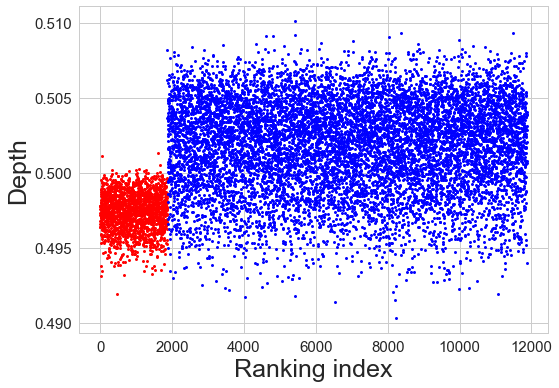

At the start, number of cycles = 173083 and max depth = 33.668166666666664
nb to trim = 1
Step 1 number of cycles = 173083 and max depth = 33.6700558379865
nb to trim = 1
Step 2 number of cycles = 173083 and max depth = 33.670861810301716
nb to trim = 1
Step 3 number of cycles = 173083 and max depth = 33.671667916979246
nb to trim = 1
Step 4 number of cycles = 173083 and max depth = 33.67197399133045
nb to trim = 1
Step 5 number of cycles = 173083 and max depth = 33.67261358899541
nb to trim = 1
Step 6 number of cycles = 173083 and max depth = 33.673336668334166
nb to trim = 1
Step 7 number of cycles = 173083 and max depth = 33.67264237471859
nb to trim = 1
Step 8 number of cycles = 173083 and max depth = 33.67386591060707
nb to trim = 1
Step 9 number of cycles = 173083 and max depth = 33.6740055041281
nb to trim = 1
Step 10 number of cycles = 173083 and max depth = 33.67531276063386
nb to trim = 1
Step 11 number of cycles = 173083 and max depth = 33.676203186254064
nb to trim = 1
Step

nb to trim = 1
Step 99 number of cycles = 129792 and max depth = 33.72901436854046
nb to trim = 1
Step 100 number of cycles = 129792 and max depth = 33.72991596638656
nb to trim = 1
Step 101 number of cycles = 129792 and max depth = 33.73157408185561
nb to trim = 1
Step 102 number of cycles = 129792 and max depth = 33.732812237350814
nb to trim = 1
Step 103 number of cycles = 129792 and max depth = 33.732537614524674
nb to trim = 1
Step 104 number of cycles = 129792 and max depth = 33.732767316745125
nb to trim = 1
Step 105 number of cycles = 129792 and max depth = 33.7338377469525
nb to trim = 1
Step 106 number of cycles = 129792 and max depth = 33.735160585169
nb to trim = 1
Step 107 number of cycles = 129792 and max depth = 33.73564281510132
nb to trim = 1
Step 108 number of cycles = 129792 and max depth = 33.736377396569125
nb to trim = 1
Step 109 number of cycles = 129792 and max depth = 33.73702800437306
nb to trim = 1
Step 110 number of cycles = 129792 and max depth = 33.7380151

nb to trim = 1
Step 197 number of cycles = 121576 and max depth = 33.809878844361606
nb to trim = 1
Step 198 number of cycles = 121576 and max depth = 33.81087951194713
nb to trim = 1
Step 199 number of cycles = 121576 and max depth = 33.81204982628591
nb to trim = 1
Step 200 number of cycles = 121576 and max depth = 33.81279661016949
nb to trim = 1
Step 201 number of cycles = 121576 and max depth = 33.814475803034156
nb to trim = 1
Step 202 number of cycles = 121576 and max depth = 33.81581624004068
nb to trim = 1
Step 203 number of cycles = 121576 and max depth = 33.81690260235653
nb to trim = 1
Step 204 number of cycles = 121576 and max depth = 33.81748050186504
nb to trim = 1
Step 205 number of cycles = 121576 and max depth = 33.81805849936414
nb to trim = 1
Step 206 number of cycles = 121576 and max depth = 33.81923011700865
nb to trim = 1
Step 207 number of cycles = 121576 and max depth = 33.8201475451539
nb to trim = 1
Step 208 number of cycles = 121576 and max depth = 33.821828

nb to trim = 1
Step 295 number of cycles = 99934 and max depth = 33.94318667236224
nb to trim = 1
Step 296 number of cycles = 77161 and max depth = 33.94454887218045
nb to trim = 1
Step 297 number of cycles = 87627 and max depth = 33.94582585661796
nb to trim = 1
Step 298 number of cycles = 87627 and max depth = 33.94735942573919
nb to trim = 1
Step 299 number of cycles = 87627 and max depth = 33.949235108110415
nb to trim = 1
Step 300 number of cycles = 87627 and max depth = 33.95068376068376
nb to trim = 1
Step 301 number of cycles = 87627 and max depth = 33.95196170612873
nb to trim = 1
Step 302 number of cycles = 87627 and max depth = 33.953496324157975
nb to trim = 1
Step 303 number of cycles = 87627 and max depth = 33.95503120458237
nb to trim = 1
Step 304 number of cycles = 87627 and max depth = 33.95656634746922
nb to trim = 1
Step 305 number of cycles = 87627 and max depth = 33.95767421975203
nb to trim = 1
Step 306 number of cycles = 87627 and max depth = 33.9590388233282
nb 

nb to trim = 1
Step 394 number of cycles = 17848 and max depth = 34.089522660692744
nb to trim = 1
Step 395 number of cycles = 19474 and max depth = 34.09108143041792
nb to trim = 1
Step 396 number of cycles = 19474 and max depth = 34.09238193726301
nb to trim = 1
Step 397 number of cycles = 19474 and max depth = 34.09394122209773
nb to trim = 1
Step 398 number of cycles = 19474 and max depth = 34.094897431477335
nb to trim = 1
Step 399 number of cycles = 19474 and max depth = 34.09645720196535
nb to trim = 1
Step 400 number of cycles = 19474 and max depth = 34.09827586206897
nb to trim = 1
Step 401 number of cycles = 19474 and max depth = 34.10000862143288
nb to trim = 1
Step 402 number of cycles = 19474 and max depth = 34.1018279013623
nb to trim = 1
Step 403 number of cycles = 19474 and max depth = 34.10330257825299
nb to trim = 1
Step 404 number of cycles = 19474 and max depth = 34.10460503621939
nb to trim = 1
Step 405 number of cycles = 19474 and max depth = 34.10599396291505
nb 

nb to trim = 1
Step 493 number of cycles = 6729 and max depth = 34.25299843559882
nb to trim = 1
Step 494 number of cycles = 6729 and max depth = 34.25449804432856
nb to trim = 1
Step 495 number of cycles = 3997 and max depth = 34.256084840055635
nb to trim = 1
Step 496 number of cycles = 4092 and max depth = 34.25767191167522
nb to trim = 1
Step 497 number of cycles = 4092 and max depth = 34.25908537645627
nb to trim = 1
Step 498 number of cycles = 4092 and max depth = 34.26023824015303
nb to trim = 1
Step 499 number of cycles = 4092 and max depth = 34.26428385076963
nb to trim = 1
Step 500 number of cycles = 4092 and max depth = 34.26587232562185
nb to trim = 1
Step 501 number of cycles = 4092 and max depth = 34.26746107680265
nb to trim = 1
Step 502 number of cycles = 4092 and max depth = 34.26887613082811
nb to trim = 1
Step 503 number of cycles = 4092 and max depth = 34.27055241409309
nb to trim = 1
Step 504 number of cycles = 4092 and max depth = 34.27188098138159
nb to trim = 1


nb to trim = 1
Step 594 number of cycles = 529 and max depth = 34.44448345475292
nb to trim = 1
Step 595 number of cycles = 529 and max depth = 34.445926966292134
nb to trim = 1
Step 596 number of cycles = 529 and max depth = 34.44754630848916
nb to trim = 1
Step 597 number of cycles = 529 and max depth = 34.452669476642086
nb to trim = 1
Step 598 number of cycles = 529 and max depth = 34.454465618687976
nb to trim = 1
Step 599 number of cycles = 529 and max depth = 34.456086421921654
nb to trim = 1
Step 600 number of cycles = 529 and max depth = 34.457883179622314
nb to trim = 1
Step 601 number of cycles = 529 and max depth = 34.459680252986644
nb to trim = 1
Step 602 number of cycles = 529 and max depth = 34.461214091188616
nb to trim = 1
Step 603 number of cycles = 529 and max depth = 34.462923914953436
nb to trim = 1
Step 604 number of cycles = 529 and max depth = 34.464370441964675
nb to trim = 1
Step 605 number of cycles = 529 and max depth = 34.46608084358523
nb to trim = 1
Step

nb to trim = 1
Step 696 number of cycles = 10 and max depth = 34.67866643021812
nb to trim = 1
Step 697 number of cycles = 10 and max depth = 34.68656319290466
nb to trim = 1
Step 698 number of cycles = 10 and max depth = 34.689107681390816
nb to trim = 1
Step 699 number of cycles = 10 and max depth = 34.69165262130755
nb to trim = 1
Step 700 number of cycles = 10 and max depth = 34.69410929737403
nb to trim = 1
Step 701 number of cycles = 10 and max depth = 34.69638896282495
nb to trim = 1
Step 702 number of cycles = 10 and max depth = 34.698580301685894
nb to trim = 1
Step 703 number of cycles = 10 and max depth = 34.70094950749845
nb to trim = 1
Step 704 number of cycles = 10 and max depth = 34.70358537451189
nb to trim = 1
Step 705 number of cycles = 10 and max depth = 34.708148411148585
nb to trim = 1
Step 706 number of cycles = 10 and max depth = 34.710608078118064
nb to trim = 1
Step 707 number of cycles = 10 and max depth = 34.712890625
nb to trim = 1
Step 708 number of cycles 

Step 799 number of cycles = 2 and max depth = 35.00646261556413
nb to trim = 1
Step 800 number of cycles = 2 and max depth = 35.00870736086176
nb to trim = 1
Step 801 number of cycles = 2 and max depth = 35.01140138252985
nb to trim = 1
Step 802 number of cycles = 2 and max depth = 35.013826539773746
nb to trim = 1
Step 803 number of cycles = 2 and max depth = 35.01634192331866
nb to trim = 1
Step 804 number of cycles = 2 and max depth = 35.01885775862068
nb to trim = 1
Step 805 number of cycles = 2 and max depth = 35.021104625056125
nb to trim = 1
Step 806 number of cycles = 2 and max depth = 35.02344171007724
nb to trim = 1
Step 807 number of cycles = 2 and max depth = 35.025599568849366
nb to trim = 1
Step 808 number of cycles = 2 and max depth = 35.027757815307226
nb to trim = 1
Step 809 number of cycles = 2 and max depth = 35.032973944294696
nb to trim = 1
Step 810 number of cycles = 2 and max depth = 35.035313145835204
nb to trim = 1
Step 811 number of cycles = 2 and max depth = 

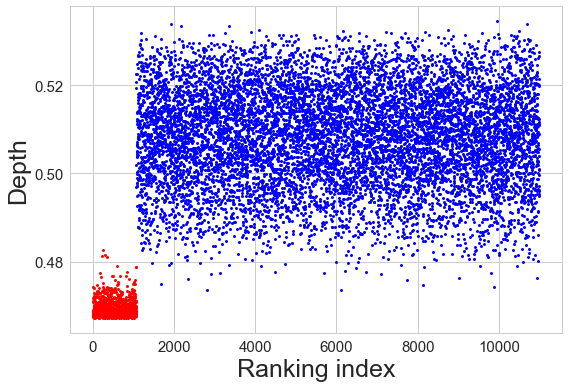

Number of pts trimmed in the clean sample = 79
Number of pts trimmed in the contaminated sample = 895


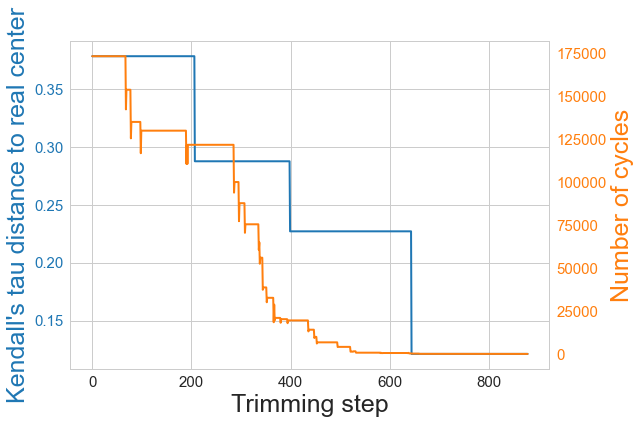

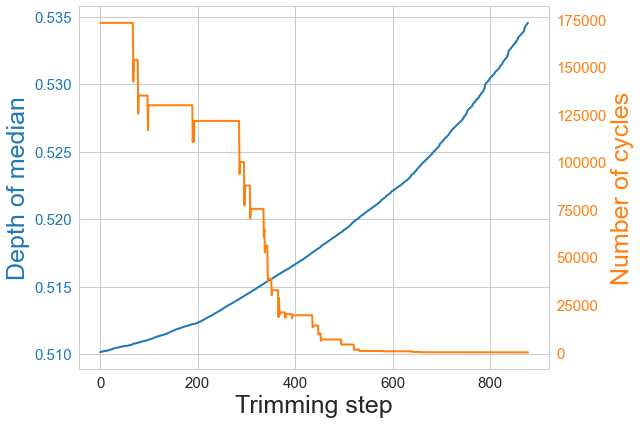

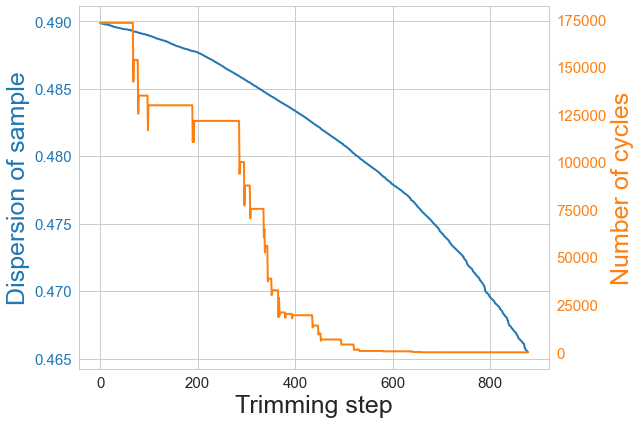

In [412]:
np.random.seed(0)
n = 12
ratio_contamination = 0.2
m0 = 10000
m = [int(m0), int(ratio_contamination*m0)]
thetas = [0.1, 0.9]
x, y, y_depth, y_dispersion, new_samples, medians, cycles = lauch_exp(n=n, m=m, thetas=thetas)
y_bis = np.asarray(y)/( n*(n-1)/2 )
y_depth_bis = np.asarray(y_depth)/( n*(n-1)/2 )
y_dispersion_bis = np.asarray(y_dispersion)/(n*(n-1)/2)

which = "kendall"
save_path = "/Users/m.goibert/Documents/Criteo/P3_Ranking/Depth_fct/plots_mo/trimming_n="+str(n)+"_m="+str(m)+"_thetas="+str(thetas)+"_"+which+".png"
plot_exp(x, y_bis, cycles, which, save_path=save_path)

which = "depth"
save_path = "/Users/m.goibert/Documents/Criteo/P3_Ranking/Depth_fct/plots_mo/trimming_n="+str(n)+"_m="+str(m)+"_thetas="+str(thetas)+"_"+which+".png"
plot_exp(x, y_depth_bis, cycles, which, save_path=save_path)

which = "dispersion"
save_path = "/Users/m.goibert/Documents/Criteo/P3_Ranking/Depth_fct/plots_mo/trimming_n="+str(n)+"_m="+str(m)+"_thetas="+str(thetas)+"_"+which+".png"
plot_exp(x, y_dispersion_bis, cycles, which, save_path=save_path)

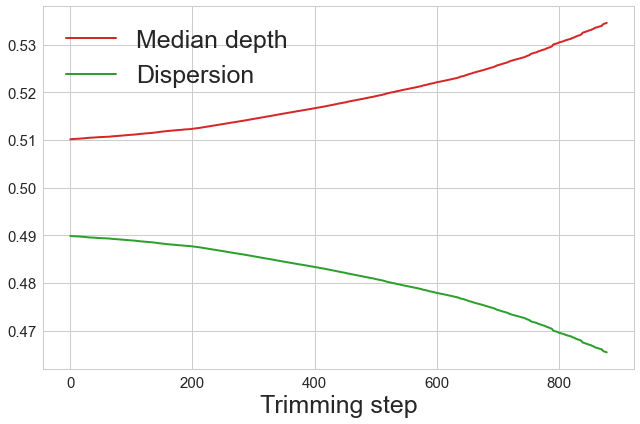

In [406]:
def plot_exp_v2(x, y, y2=None, y3=None, cycles=None, which="kendall", save_path=None):
    plt.style.use('seaborn-whitegrid')
    fig, ax1 = plt.subplots(figsize=(9,6))

    color = 'tab:blue'
    ax1.set_xlabel(f"Trimming step", fontsize=25)
    if which == "kendall":
        ax1.set_ylabel(f"Kendall's tau distance to real center", fontsize=25, color=color)
    elif which == "depth":
        ax1.set_ylabel(f"Depth of median", fontsize=25, color=color)
    elif which == "dispersion":
        ax1.set_ylabel(f"Dispersion of sample", fontsize=25, color=color)
    #else:
        #ax1.set_ylabel(f"", fontsize=25, color="black")
    if y != None:
        ax1.plot(x, np.reshape(np.asarray(list(y.values())), np.asarray(list(y.values())).shape[1]), "-", linewidth=2, color=color, label=list(y.keys())[0])
    if y2 != None:
        ax1.plot(x, np.reshape(np.asarray(list(y2.values())), np.asarray(list(y2.values())).shape[1]), "-", linewidth=2, color='tab:red', label=list(y2.keys())[0])
    if y3 != None:
        ax1.plot(x, np.reshape(np.asarray(list(y3.values())), np.asarray(list(y3.values())).shape[1]), "-", linewidth=2, color='tab:green', label=list(y3.keys())[0])
    #ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(labelsize=15)
    ax1.legend(fontsize=25)
    plt.grid(True)
    
    if cycles != None:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:orange'
        ax2.set_ylabel('Number of cycles', fontsize=15, color=color)  # we already handled the x-label with ax1
        ax2.plot(x, cycles, linewidth=2, color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        plt.grid(False)

    #plt.title('Trimming strategy by depth', fontsize=20)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    if save_path != None:
        plt.savefig(save_path, dpi=400)
    plt.show()

which = "dispersion_and_depth"
save_path = "/Users/m.goibert/Documents/Criteo/P3_Ranking/Depth_fct/plots_mo/trimming_n="+str(n)+"_m="+str(m)+"_thetas="+str(thetas)+"_"+which+".png"
plot_exp_v2(x, None, {"Median depth": y_depth_bis}, {"Dispersion": y_dispersion_bis}, cycles=None, which=which, save_path=save_path)

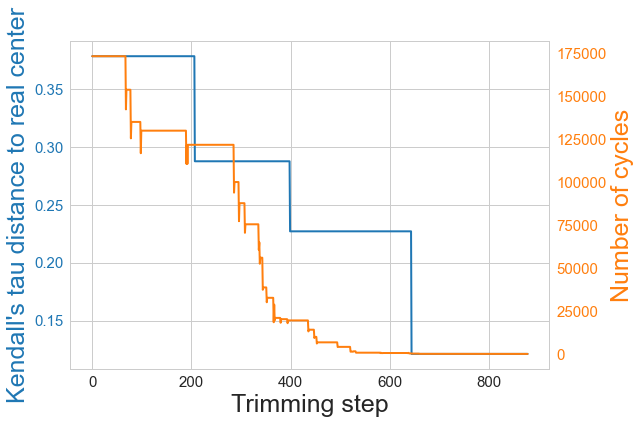

In [405]:
which = "kendall"
save_path = "/Users/m.goibert/Documents/Criteo/P3_Ranking/Depth_fct/plots_mo/trimming_n="+str(n)+"_m="+str(m)+"_thetas="+str(thetas)+"_"+which+".png"
plot_exp(x, y_bis, cycles, which, save_path=save_path)

In [388]:
a = np.array([[1,2,3]])
a2 = np.reshape(a, 3)
a2

array([1, 2, 3])

In [249]:
#plot_exp(x, y_bis, cycles, save_path=save_path)
y[len(y)-1]

9

In [369]:
theta = 0.1
phi = None
mk.check_theta_phi(theta, phi)

(array(0.1), array(0.90483742))

In [370]:
theta = 0.9
phi = None
mk.check_theta_phi(theta, phi)

(array(0.9), array(0.40656966))